In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

pd.set_option('future.no_silent_downcasting', True)

# Testing methods on a randomly generated set of points

We generate two clusters using the _make_blobs_ function from the Scikit-learn library. Next, we randomly select a subset of samples to serve as labeled data, while the remaining samples remain unlabeled. However, the true labels of all samples are retained for accuracy calculation purposes.

In [2]:
random.seed(95) #We set a seed for reproducibility of results

In [3]:
a = random.random()*10
b = random.random()*10

a_std = random.random()
b_std = random.random()

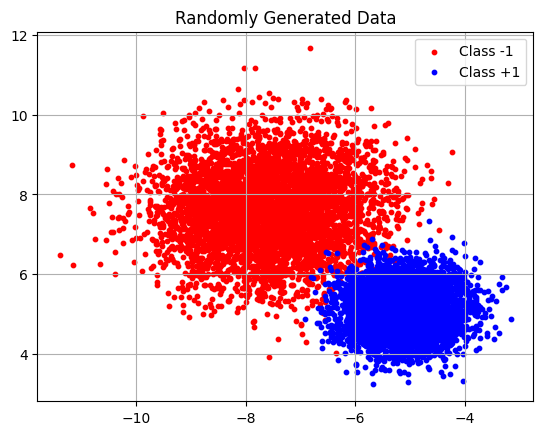

In [4]:
centers = [(-a, a), (-b, b)]
cluster_std = [a_std, b_std]

X, y = make_blobs(n_samples=10000, cluster_std=cluster_std, centers=centers, n_features=3, random_state=123)
y[y==0] = -1

plt.title('Randomly Generated Data')
plt.scatter(X[y == -1, 0], X[y == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X[y == 1, 0], X[y == 1, 1],color="blue", s=10, label="Class +1")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
idx_class_0 = np.where(y == -1)[0]
idx_class_1 = np.where(y == 1)[0]

#We consider 1% of the data to be our labeled samples

a_k = int(len(idx_class_0) * 0.01)
b_k = int(len(idx_class_1) * 0.01)

a_indices = random.sample(list(idx_class_0), a_k)
b_indices = random.sample(list(idx_class_1), b_k)


class_1 = X[a_indices]
class_2 = X[b_indices]


remove_indices = set(a_indices + b_indices)
keep_indices = [i for i in range(len(X)) if i not in remove_indices]


X_unlabeled = X[keep_indices]
y_unlabeled_true = y[keep_indices]

X_labeled = np.concatenate((class_1,class_2))
y_labeled = np.concatenate((y[a_indices],y[b_indices]))

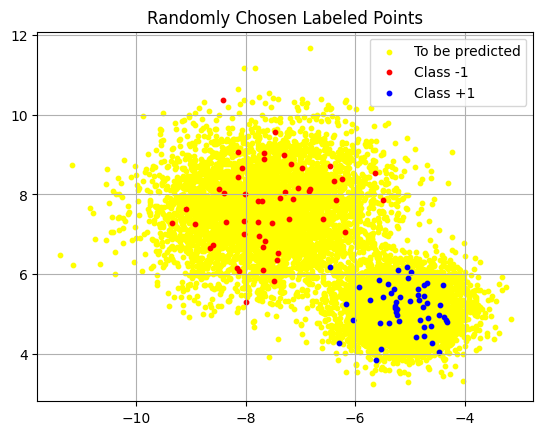

In [6]:
plt.title('Randomly Chosen Labeled Points')
plt.scatter(X_unlabeled[:,0], X_unlabeled[:,1], s = 10, color = 'yellow', label = 'To be predicted')
plt.scatter(class_1[:,0], class_1[:,1], s = 10, color = 'red', label = 'Class -1')
plt.scatter(class_2[:,0], class_2[:,1], s = 10, color = 'blue', label = 'Class +1')
plt.legend()
plt.grid(True)
plt.show()

## Defining Weights

The weights define the notion of similarity between points. For this assignment, a Gaussian kernel is used to measure similarity both between labeled and unlabeled points, as well as between unlabeled points themselves.

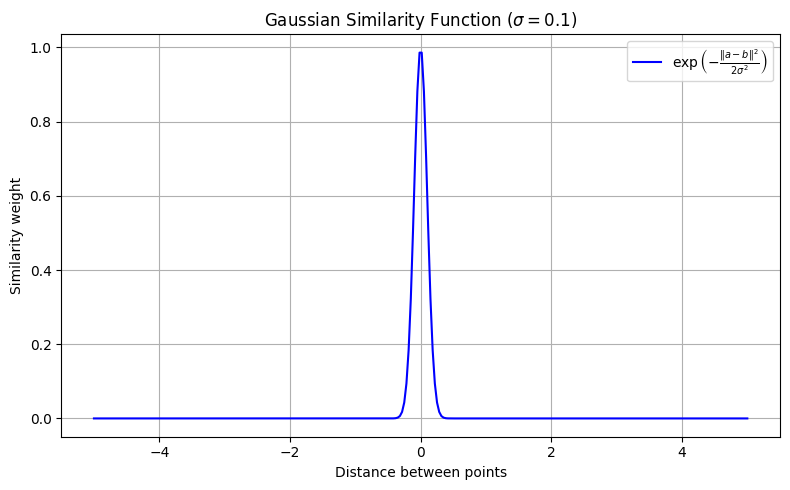

In [7]:
distances = np.linspace(-5, 5, 300)
sigma = 0.1

weights = np.exp(-distances**2 / (2 * sigma**2))

plt.figure(figsize=(8, 5))
plt.plot(distances, weights, label=r"$\exp\left(-\frac{{\|a - b\|^2}}{{2\sigma^2}}\right)$", color="blue")
plt.xlabel("Distance between points")
plt.ylabel("Similarity weight")
plt.title(rf"Gaussian Similarity Function ($\sigma={sigma}$)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def compute_w_lu(X_labeled, X_unlabeled, sigma=0.1):
    dists = np.linalg.norm(X_labeled[:, None, :] - X_unlabeled[None, :, :], axis=2)
    return np.exp(-dists**2 / (2 * sigma**2))

def compute_w_uu(X_unlabeled, sigma=0.1):
    dists = np.linalg.norm(X_unlabeled[:, None, :] - X_unlabeled[None, :, :], axis=2)
    return np.exp(-dists**2 / (2 * sigma**2))

In [9]:
X_all = np.vstack([X_labeled, X_unlabeled])
mean = X_all.mean(axis=0)
std = X_all.std(axis=0) + 1e-8  

X_labeled_scaled = (X_labeled - mean) / std
X_unlabeled_scaled = (X_unlabeled - mean) / std

In [10]:
weights_lu = compute_w_lu(X_labeled_scaled, X_unlabeled_scaled, sigma = 0.1)
weights_uu = compute_w_uu(X_unlabeled_scaled, sigma = 0.1)

## Loss Function

Here is the implementation of the loss function we were asked to consider for our assignment, which computes the weighted differences between labeled and unlabeled data points.

In [11]:
def Loss(y_unlabeled, y_labeled, weights_lu, weights_uu):
    
    diff_lu = y_unlabeled[None, :] - y_labeled[:, None]
    sum_lu = np.sum(weights_lu * diff_lu**2)

    diff_uu = y_unlabeled[:, None] - y_unlabeled[None, :]
    sum_uu = np.sum(weights_uu * diff_uu**2)

    return sum_lu + 0.5 * sum_uu

## Hessian Matrix and Best Parameters

The theory seen in class and existing literature are valuable resources for selecting the optimal parameters for our gradient-based methods. We proceed to compute them, as obtaining the Hessian matrix of our loss function is straightforward.

In [12]:
def best_parameters(weights_lu, weights_uu):
    diagonal = []

    for i in range(weights_uu.shape[0]):
        d = np.sum(weights_lu[:,i]) + np.sum(weights_uu[i,:]) 
        diagonal.append(d*2)
    
    
    Hessian = -weights_uu.copy()
    Hessian = Hessian*2
    np.fill_diagonal(Hessian,diagonal)


    eigvals = np.linalg.eigvalsh(Hessian)

    sigma = min(eigvals)
    L = max(eigvals)
    k = L/sigma

    

    best_GD = 1/L
    best_GDIR = 2/(sigma + L)
    best_HB = [4/(np.sqrt(L)+np.sqrt(sigma))**2, ((np.sqrt(k)-1)/(np.sqrt(k)+1))**2]
    best_AGM = [1/L, (np.sqrt(k)-1)/(np.sqrt(k)+1)]

    return best_GD, best_GDIR, best_HB, best_AGM

In [13]:
best_alpha_GD, best_alpha_GDIR, best_HB, best_AGM = best_parameters(weights_lu, weights_uu)
best_alpha_HB, best_beta_HB = best_HB
best_alpha_AGM, best_beta_AGM = best_AGM

## Gradient Based Methods

We define some auxiliary functions for the computation of the Gradient Based Methods

In [14]:
def partial_derivative(j,y_unlabeled, y_labeled, weights_lu, weights_uu):

    sum_lu = np.sum(weights_lu[:, j] * (y_unlabeled[j] - y_labeled))  
    sum_uu = np.sum(weights_uu[j, :] * (y_unlabeled[j] - y_unlabeled))

    
    return 2*(sum_lu + sum_uu)

In [15]:
def gradient(y_unlabeled, y_labeled, weights_lu, weights_uu):

    gradient = []

    for j in range(len(y_unlabeled)):
        gradient.append(partial_derivative(j, y_unlabeled, y_labeled, weights_lu, weights_uu))
    
    return np.array(gradient)

### Gradient Descent Method

In [16]:
def Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha=0.01, epochs=100):

    y_unlabeled = np.random.uniform(-1, 1, size = X_unlabeled.shape[0])
    accuracies = []
    loss_list = []
    times = []

    time_total = 0

    for _ in range(epochs):

        start = time.time()
        
        grad = gradient(y_unlabeled, y_labeled, weights_lu, weights_uu)

        if np.linalg.norm(grad) < 1e-6:
            break
        
        y_unlabeled -= alpha * grad
        y_unlabeled = np.clip(y_unlabeled, -1, 1)
        loss = Loss(y_unlabeled, y_labeled, weights_lu, weights_uu)
        accuracy = np.mean(np.sign(y_unlabeled) == y_unlabeled_true)
        
        end = time.time()
        time_total += (end-start)

        times.append(time_total)
        loss_list.append(loss)
        accuracies.append(accuracy)
    
    return np.sign(y_unlabeled), accuracies, loss_list, times

In [17]:
y_final_pred_GD, accuracies_GD, loss_GD, times_GD = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GD, epochs=100)

In [18]:
accuracy_GD = accuracies_GD[-1]
print(accuracy_GD)

0.9614141414141414


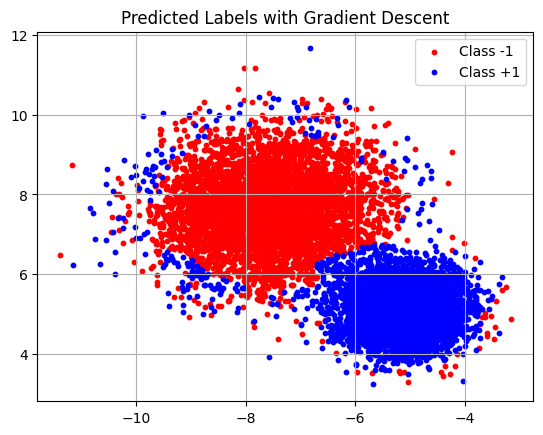

In [19]:
plt.title('Predicted Labels with Gradient Descent')
plt.scatter(X_unlabeled[y_final_pred_GD == -1, 0], X_unlabeled[y_final_pred_GD == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_GD == 1, 0], X_unlabeled[y_final_pred_GD == 1, 1],color="blue", s=10, label="Class +1")
plt.legend()
plt.grid(True)
plt.savefig('Predicted_GD_SD.png', dpi=300, bbox_inches='tight')
plt.show()

### Gradient Descent with Improved Rate

In [20]:
y_final_pred_GDIR, accuracies_GDIR, loss_GDIR, times_GDIR = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GDIR, epochs=100)

In [21]:
accuracy_GDIR = accuracies_GDIR[-1]
print(accuracy_GDIR)

0.9674747474747475


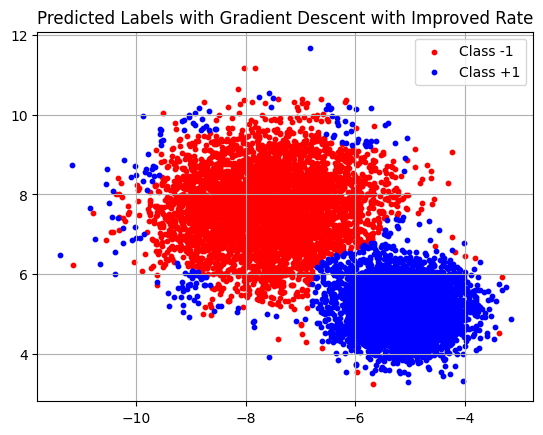

In [22]:
plt.title('Predicted Labels with Gradient Descent with Improved Rate')
plt.scatter(X_unlabeled[y_final_pred_GDIR == -1, 0], X_unlabeled[y_final_pred_GDIR == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_GDIR == 1, 0], X_unlabeled[y_final_pred_GDIR == 1, 1],color="blue", s=10, label="Class +1")
plt.legend()
plt.grid(True)
plt.savefig('Predicted_GDIR_SD.png', dpi=300, bbox_inches='tight')
plt.show()

### Heavy Ball

In [23]:
def Heavy_ball(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha=0.01, beta=0.01, epochs=100):
    
    y_unlabeled = np.random.uniform(-1, 1, size=X_unlabeled.shape[0])
    y_unlabeled_last = y_unlabeled.copy()
    accuracies = []
    loss_list = []
    times = []

    time_total = 0    

    for _ in range(epochs):

        start = time.time()
        
        grad = gradient(y_unlabeled, y_labeled, weights_lu, weights_uu)

        if np.linalg.norm(grad) < 1e-6:
            break
        
        y_new = y_unlabeled - alpha * grad + beta * (y_unlabeled - y_unlabeled_last)
        y_unlabeled_last = y_unlabeled
        y_unlabeled = np.clip(y_new, -1, 1)
        loss = Loss(y_unlabeled, y_labeled, weights_lu, weights_uu)
        accuracy = np.mean(np.sign(y_unlabeled) == y_unlabeled_true)

        end = time.time()
        time_total += (end-start)

        times.append(time_total)
        loss_list.append(loss)
        accuracies.append(accuracy)

    return np.sign(y_unlabeled), accuracies, loss_list, times

In [24]:
y_final_pred_HB, accuracies_HB, loss_HB, times_HB = Heavy_ball(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_HB, beta = best_beta_HB, epochs=100)

In [25]:
accuracy_HB = accuracies_HB[-1]
print(accuracy_HB)

0.9854545454545455


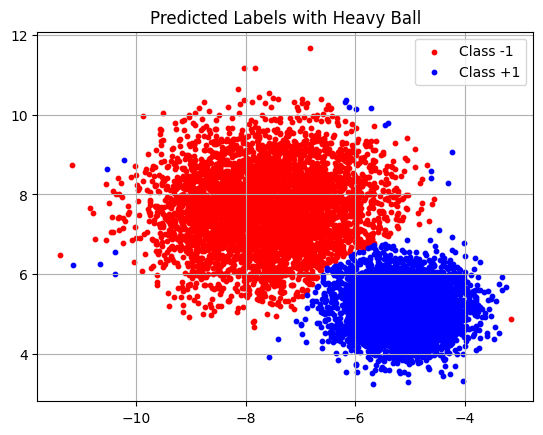

In [26]:
plt.title('Predicted Labels with Heavy Ball')
plt.scatter(X_unlabeled[y_final_pred_HB == -1, 0], X_unlabeled[y_final_pred_HB == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_HB == 1, 0], X_unlabeled[y_final_pred_HB == 1, 1],color="blue", s=10, label="Class +1")
plt.legend()
plt.grid(True)
plt.savefig('Predicted_HB_SD.png', dpi=300, bbox_inches='tight')
plt.show()

### Accelerated Gradient Method

In [27]:
def AGM(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha=0.01, beta=0.01, epochs=100):

    y_unlabeled = np.random.uniform(-1, 1, size=X_unlabeled.shape[0])
    y_unlabeled_last = y_unlabeled.copy()
    accuracies = []
    loss_list = []
    times = []

    time_total = 0

    for _ in range(epochs):

        start = time.time()

        y_aux = y_unlabeled + beta * (y_unlabeled - y_unlabeled_last)
        grad = gradient(y_aux, y_labeled, weights_lu, weights_uu)

        if np.linalg.norm(grad) < 1e-6:
            break
        
        y_new = y_aux - alpha * grad
        y_unlabeled_last = y_unlabeled
        y_unlabeled = np.clip(y_new, -1, 1)
        loss = Loss(y_unlabeled, y_labeled, weights_lu, weights_uu)
        accuracy = np.mean(np.sign(y_unlabeled) == y_unlabeled_true)

        end = time.time()
        time_total += (end-start)

        times.append(time_total)
        loss_list.append(loss)
        accuracies.append(accuracy)

    return np.sign(y_unlabeled), accuracies, loss_list, times

In [28]:
y_final_pred_AGM, accuracies_AGM, loss_AGM, times_AGM = AGM(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_AGM, beta = best_beta_AGM, epochs=100)

In [29]:
accuracy_AGM = accuracies_AGM[-1]
print(accuracy_AGM)

0.9812121212121212


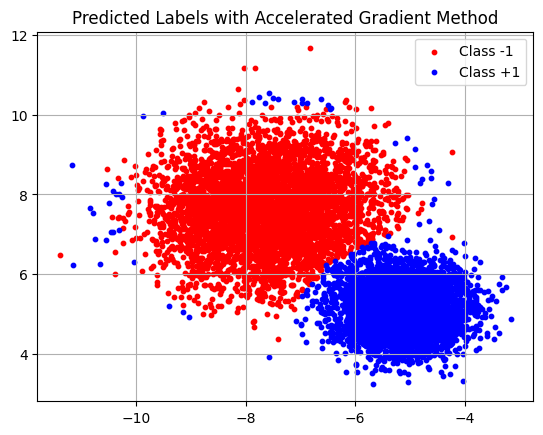

In [30]:
plt.title('Predicted Labels with Accelerated Gradient Method')
plt.scatter(X_unlabeled[y_final_pred_AGM == -1, 0], X_unlabeled[y_final_pred_AGM == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_AGM == 1, 0], X_unlabeled[y_final_pred_AGM == 1, 1],color="blue", s=10, label="Class +1")
plt.legend()
plt.grid(True)
plt.savefig('Predicted_AGM_SD.png', dpi=300, bbox_inches='tight')
plt.show()

## Block Coordinate Gradient Descent with Gauss-Southwell Rule

In [31]:
def compute_lipschitz_constants(weights_lu, weights_uu):
    L = np.sum(weights_lu, axis=0) + np.sum(weights_uu, axis=1)
    return 2 * L

In [32]:
def BCGD_GS(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, max_epochs=100):
    import time

    y_unlabeled = np.random.uniform(-1, 1, size=X_unlabeled.shape[0])
    N = len(y_unlabeled)
    max_iterations = max_epochs * N

    grad = gradient(y_unlabeled, y_labeled, weights_lu, weights_uu)
    L = compute_lipschitz_constants(weights_lu, weights_uu)

    loss_list = []
    accuracies = []
    times = []

    time_total = 0

    for it in range(max_iterations):
        start = time.time()

        j = np.argmax(np.abs(grad))
        step = grad[j] / L[j]
        y_unlabeled[j] -= step
        y_unlabeled[j] = np.clip(y_unlabeled[j], -1, 1)
        grad[j] = partial_derivative(j, y_unlabeled, y_labeled, weights_lu, weights_uu)

        end = time.time()
        time_total += (end - start)

        if np.linalg.norm(grad) < 1e-6:
            break

        if (it + 1) % N == 0:
            loss = Loss(y_unlabeled, y_labeled, weights_lu, weights_uu)
            loss_list.append(loss)

            if y_unlabeled_true is not None:
                accuracy = np.mean(np.sign(y_unlabeled) == y_unlabeled_true)
                accuracies.append(accuracy)

            times.append(time_total)

    return np.sign(y_unlabeled), accuracies, loss_list, times

In [33]:
y_final_pred_BCGD, accuracies_BCGD, loss_BCGD, times_BCGD = BCGD_GS(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, max_epochs=100)

In [34]:
accuracy_BCGD = accuracies_BCGD[-1]
print(accuracy_BCGD)

0.9831313131313131


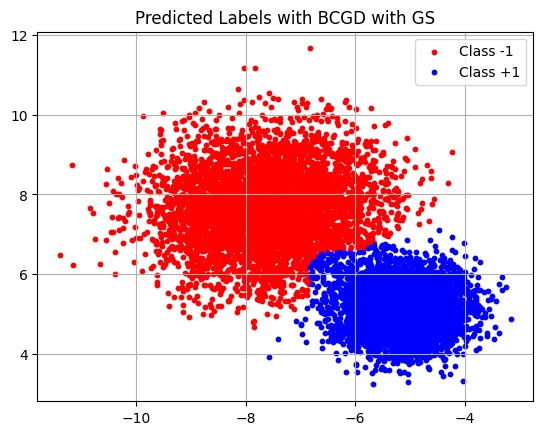

In [35]:
plt.title('Predicted Labels with BCGD with GS')
plt.scatter(X_unlabeled[y_final_pred_BCGD == -1, 0], X_unlabeled[y_final_pred_BCGD == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_BCGD == 1, 0], X_unlabeled[y_final_pred_BCGD == 1, 1],color="blue", s=10, label="Class +1")
plt.grid(True)
plt.savefig('Predicted_BCGD_SD.png', dpi=300, bbox_inches='tight')
plt.legend()

## General Comparision of Methods

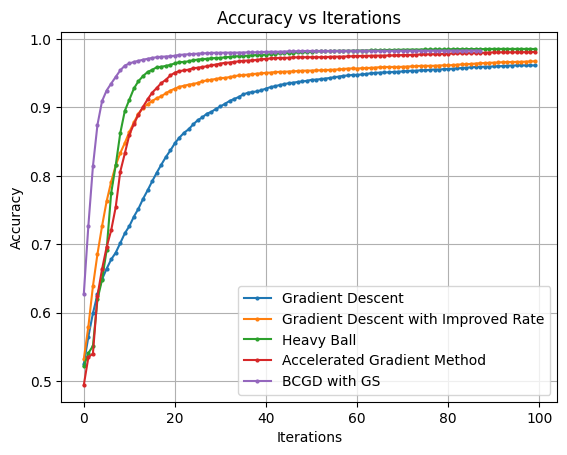

In [36]:
plt.plot(accuracies_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(accuracies_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(accuracies_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(accuracies_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(accuracies_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.savefig('acc_ite_SD.png', dpi=300, bbox_inches='tight')
plt.show()

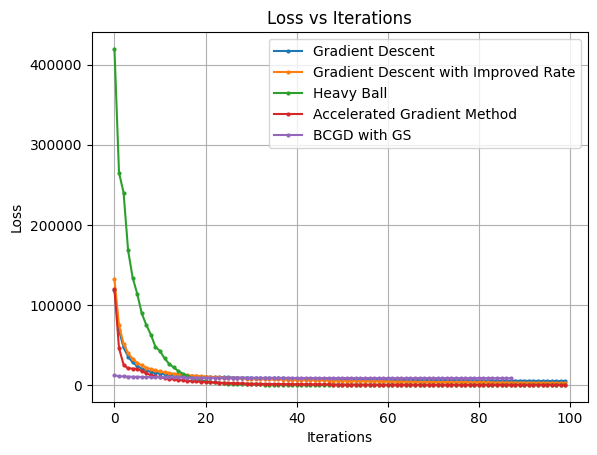

In [37]:
plt.plot(loss_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(loss_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(loss_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(loss_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(loss_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig('loss_ite_SD.png', dpi=300, bbox_inches='tight')
plt.show()

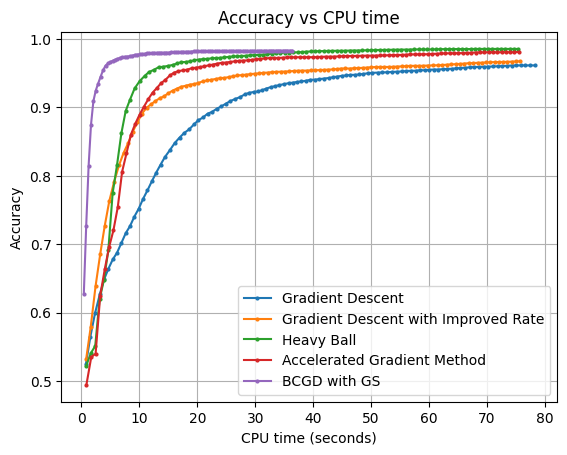

In [38]:
plt.plot(times_GD, accuracies_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(times_GDIR, accuracies_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(times_HB, accuracies_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(times_AGM, accuracies_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(times_BCGD, accuracies_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU time (seconds)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.savefig('acc_time_SD.png', dpi=300, bbox_inches='tight')
plt.show()

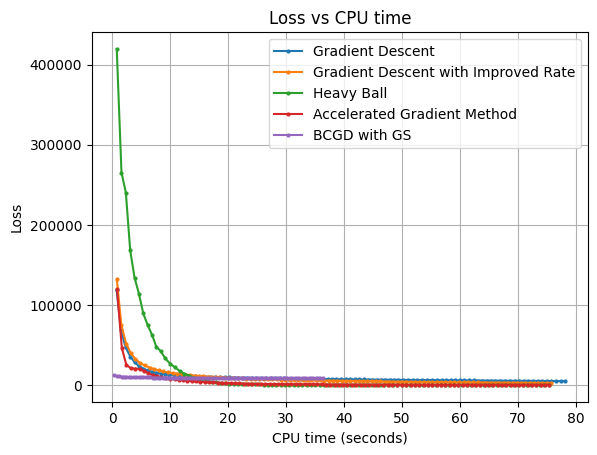

In [39]:
plt.plot(times_GD, loss_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(times_GDIR, loss_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(times_HB, loss_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(times_AGM, loss_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(times_BCGD, loss_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Loss vs CPU time")
plt.xlabel("CPU time (seconds)")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig('loss_time_SD.png', dpi=300, bbox_inches='tight')
plt.show()

# Testing the methods on a public available dataset

## Importing and Preprocessing Data

We consider the dataset _Breast Cancer Wisconsin (Diagnostic) Data Set_ available in https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/data. We are importing te data to work locally. 

In [40]:
random.seed(24) #We set a seed for reproducibility of results

In [41]:
dataset = pd.read_csv('./data.csv', sep = ',')
dataset = dataset.drop(columns = ['id', 'Unnamed: 32'])
dataset['diagnosis'] = dataset['diagnosis'].replace({'M': -1, 'B': 1}).astype('int')

In [42]:
dataset.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,-1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,-1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,-1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,-1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,-1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,-1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,-1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,-1,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,-1,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


In [43]:
y = dataset['diagnosis']
X = dataset.drop('diagnosis', axis=1).values

In [44]:
X.shape

(569, 30)

Our chosen dataset contains a substantial number of features. Including all of them is likely to impact the accuracy of our methods, as we defined our weights based on Euclidean distance, which can be influenced by the curse of dimensionality. Therefore, we reduce the dimensionality using PCA, retaining only the first two dimensions, as we have done throughout this project.

In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y 

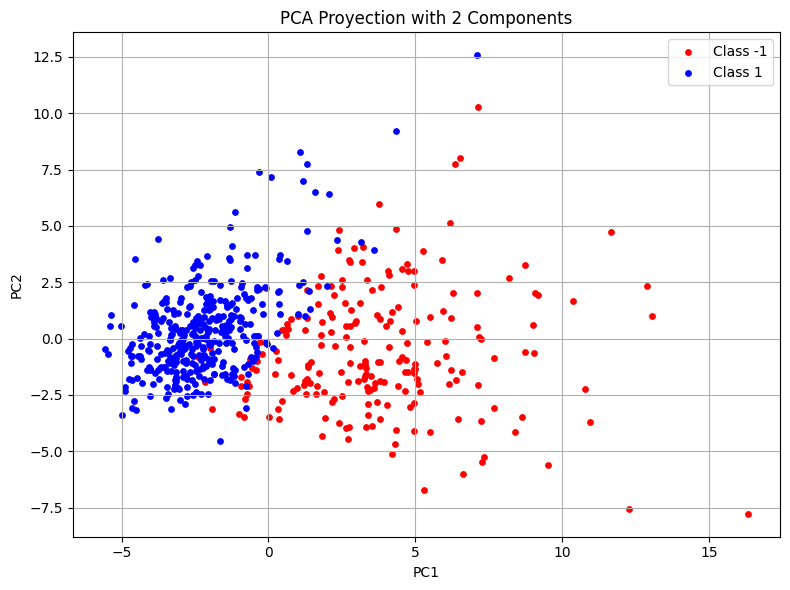

In [46]:
plt.figure(figsize=(8, 6))

for label in df_pca['label'].unique():
    subset = df_pca[df_pca['label'] == label]
    color = 'blue' if label == 1 else 'red' 
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {label}', color=color, s=15)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Proyection with 2 Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
print(np.sum(pca.explained_variance_ratio_))

0.6324320765155944


We observe that the first two dimensions of the PCA explain 63.24% of the total variability, which is satisfactory, especially when considering the results we'll present next.

We continue with the data preprocessing, as we need to select a small subset of the total data to work as our labeled samples.

In [48]:
X = df_pca.values

In [49]:
idx_class_0 = np.where(y == -1)[0]
idx_class_1 = np.where(y == 1)[0]

#We consider 5% of the data to be our labeled samples

a_k = int(len(idx_class_0) * 0.05) 
b_k = int(len(idx_class_1) * 0.05)

a_indices = random.sample(list(idx_class_0), a_k)
b_indices = random.sample(list(idx_class_1), b_k)


class_1 = X[a_indices]
class_2 = X[b_indices]


remove_indices = set(a_indices + b_indices)
keep_indices = [i for i in range(len(X)) if i not in remove_indices]


X_unlabeled = X[keep_indices]
y_unlabeled_true = y[keep_indices]

X_labeled = np.concatenate((class_1,class_2))
y_labeled = np.concatenate((y[a_indices],y[b_indices]))

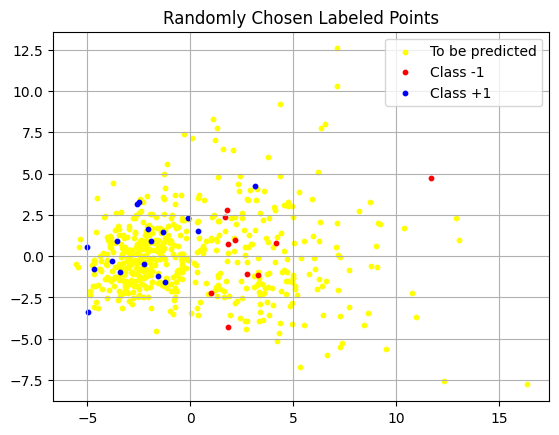

In [50]:
plt.title('Randomly Chosen Labeled Points')
plt.scatter(X_unlabeled[:,0], X_unlabeled[:,1], s = 10, color = 'yellow', label = 'To be predicted')
plt.scatter(class_1[:,0], class_1[:,1], s = 10, color = 'red', label = 'Class -1')
plt.scatter(class_2[:,0], class_2[:,1], s = 10, color = 'blue', label = 'Class +1')
plt.legend()
plt.grid(True)
plt.show()

## Defining Weights

In [51]:
X_all = np.vstack([X_labeled, X_unlabeled])
mean = X_all.mean(axis=0)
std = X_all.std(axis=0) + 1e-8  

X_labeled_scaled = (X_labeled - mean) / std
X_unlabeled_scaled = (X_unlabeled - mean) / std

In [52]:
weights_lu = compute_w_lu(X_labeled_scaled, X_unlabeled_scaled, sigma = 0.1)
weights_uu = compute_w_uu(X_unlabeled_scaled, sigma = 0.1)

## Gradient Based Methods

### Getting the Best Parameters for Each Method

In [53]:
best_alpha_GD, best_alpha_GDIR, best_HB, best_AGM = best_parameters(weights_lu, weights_uu)
best_alpha_HB, best_beta_HB = best_HB
best_alpha_AGM, best_beta_AGM = best_AGM

### Gradient Descent

In [54]:
y_final_pred_GD, accuracies_GD, loss_GD, times_GD = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GD, epochs=100)

In [55]:
accuracy_GD = accuracies_GD[-1]
print(accuracy_GD)

0.8671586715867159


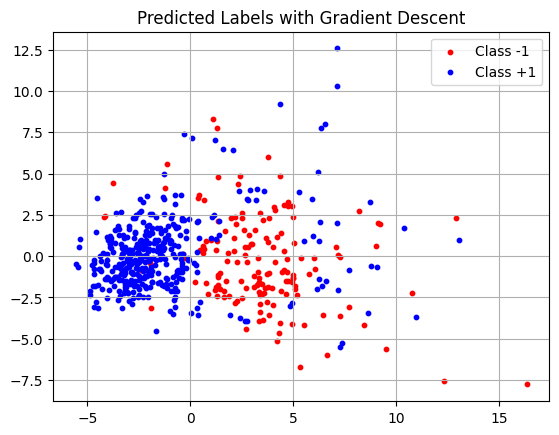

In [56]:
plt.title('Predicted Labels with Gradient Descent')
plt.scatter(X_unlabeled[y_final_pred_GD == -1, 0], X_unlabeled[y_final_pred_GD == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_GD == 1, 0], X_unlabeled[y_final_pred_GD == 1, 1],color="blue", s=10, label="Class +1")
plt.grid(True)
plt.legend()
plt.savefig('Predicted_GD_RD.png', dpi=300, bbox_inches='tight')
plt.show()

### Gradient Descent with Improved Rate

In [57]:
y_final_pred_GDIR, accuracies_GDIR, loss_GDIR, times_GDIR = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GDIR, epochs=100)

In [58]:
accuracy_GDIR = accuracies_GDIR[-1]
print(accuracy_GDIR)

0.9298892988929889


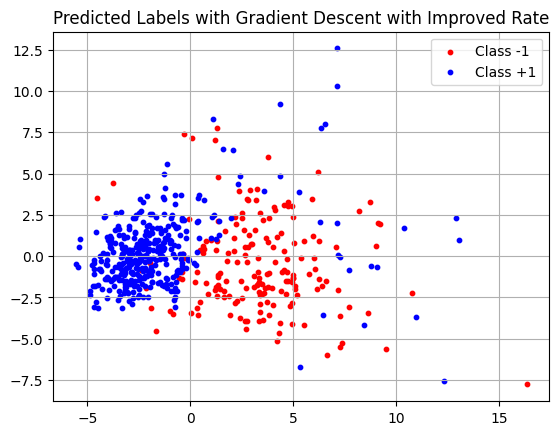

In [59]:
plt.title('Predicted Labels with Gradient Descent with Improved Rate')
plt.scatter(X_unlabeled[y_final_pred_GDIR == -1, 0], X_unlabeled[y_final_pred_GDIR == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_GDIR == 1, 0], X_unlabeled[y_final_pred_GDIR == 1, 1],color="blue", s=10, label="Class +1")
plt.grid(True)
plt.legend()
plt.savefig('Predicted_GDIR_RD.png', dpi=300, bbox_inches='tight')
plt.show()

### Heavy Ball

In [60]:
y_final_pred_HB, accuracies_HB, loss_HB, times_HB = Heavy_ball(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_HB, beta = best_beta_HB, epochs=100)

In [61]:
accuracy_HB = accuracies_HB[-1]
print(accuracy_HB)

0.9391143911439115


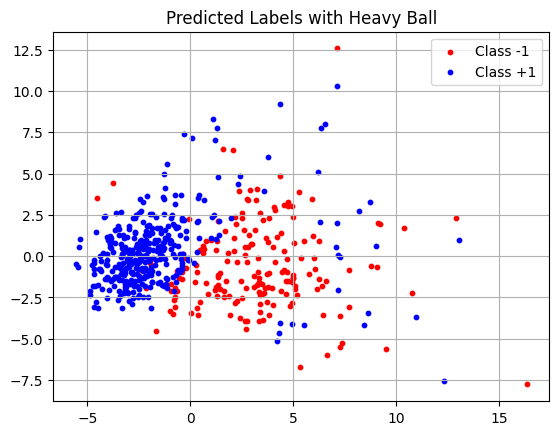

In [62]:
plt.title('Predicted Labels with Heavy Ball')
plt.scatter(X_unlabeled[y_final_pred_HB == -1, 0], X_unlabeled[y_final_pred_HB == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_HB == 1, 0], X_unlabeled[y_final_pred_HB == 1, 1],color="blue", s=10, label="Class +1")
plt.grid(True)
plt.legend()
plt.savefig('Predicted_HB_RD.png', dpi=300, bbox_inches='tight')
plt.show()

### Accelerated Gradient Method

In [63]:
y_final_pred_AGM, accuracies_AGM, loss_AGM, times_AGM = AGM(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_AGM, beta = best_beta_AGM, epochs=100)

In [64]:
accuracy_AGM = accuracies_AGM[-1]
print(accuracy_AGM)

0.9317343173431735


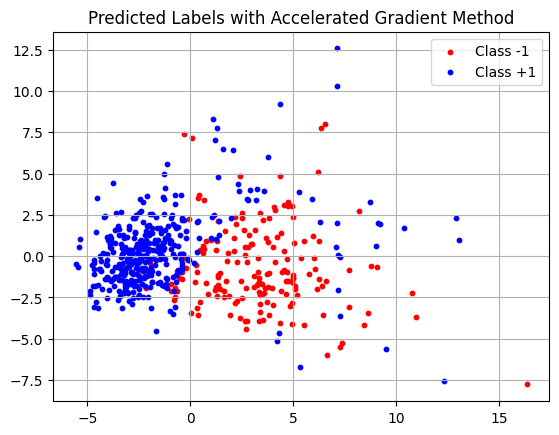

In [65]:
plt.title('Predicted Labels with Accelerated Gradient Method')
plt.scatter(X_unlabeled[y_final_pred_AGM == -1, 0], X_unlabeled[y_final_pred_AGM == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_AGM == 1, 0], X_unlabeled[y_final_pred_AGM == 1, 1],color="blue", s=10, label="Class +1")
plt.grid(True)
plt.legend()
plt.savefig('Predicted_AGM_RD.png', dpi=300, bbox_inches='tight')
plt.show()

## Block Coordinate Gradient Descent with Gauss-Southwell Rule

In [66]:
y_final_pred_BCGD, accuracies_BCGD, loss_BCGD, times_BCGD = BCGD_GS(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, max_epochs=100)

In [67]:
accuracy_BCGD = accuracies_BCGD[-1]
print(accuracy_BCGD)

0.9446494464944649


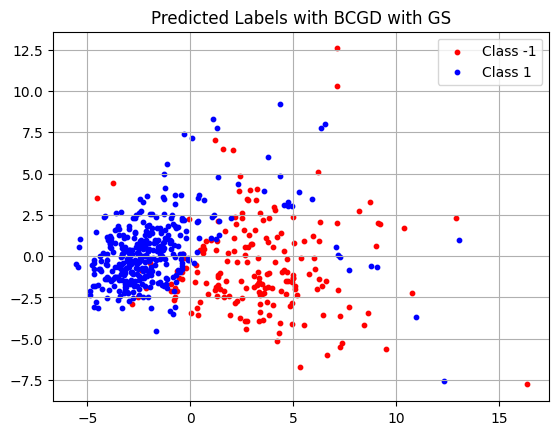

In [68]:
plt.title('Predicted Labels with BCGD with GS')
plt.scatter(X_unlabeled[y_final_pred_BCGD == -1, 0], X_unlabeled[y_final_pred_BCGD == -1, 1],color="red", s=10, label="Class -1")
plt.scatter(X_unlabeled[y_final_pred_BCGD == 1, 0], X_unlabeled[y_final_pred_BCGD == 1, 1],color="blue", s=10, label="Class 1")
plt.grid(True)
plt.legend()
plt.savefig('Predicted_BCGD_RD.png', dpi=300, bbox_inches='tight')
plt.show()

## General Comparision Between Methods

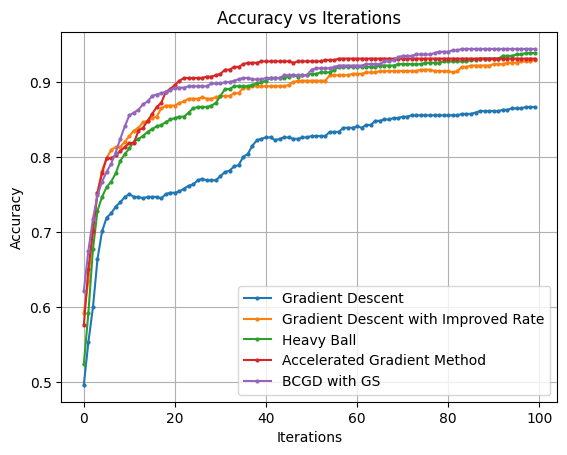

In [69]:
plt.plot(accuracies_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(accuracies_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(accuracies_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(accuracies_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(accuracies_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.savefig('acc_ite_RD.png', dpi=300, bbox_inches='tight')
plt.show()

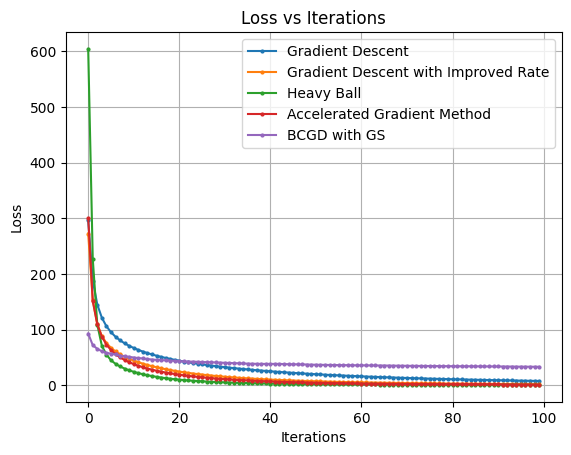

In [70]:
plt.plot(loss_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(loss_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(loss_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(loss_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(loss_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Loss vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig('loss_ite_RD.png', dpi=300, bbox_inches='tight')
plt.show()

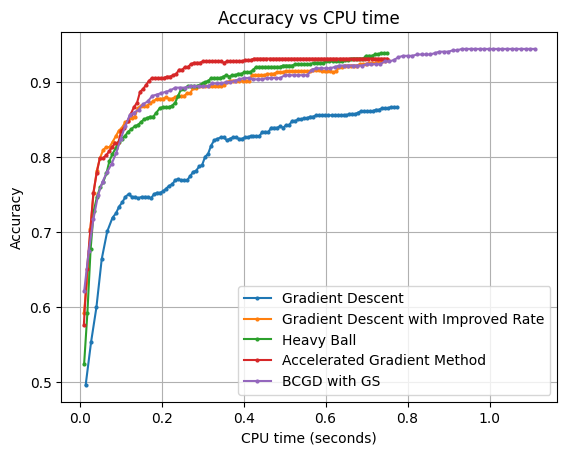

In [71]:
plt.plot(times_GD, accuracies_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(times_GDIR, accuracies_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(times_HB, accuracies_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(times_AGM, accuracies_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(times_BCGD, accuracies_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Accuracy vs CPU time")
plt.xlabel("CPU time (seconds)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.savefig('acc_time_RD.png', dpi=300, bbox_inches='tight')
plt.show()

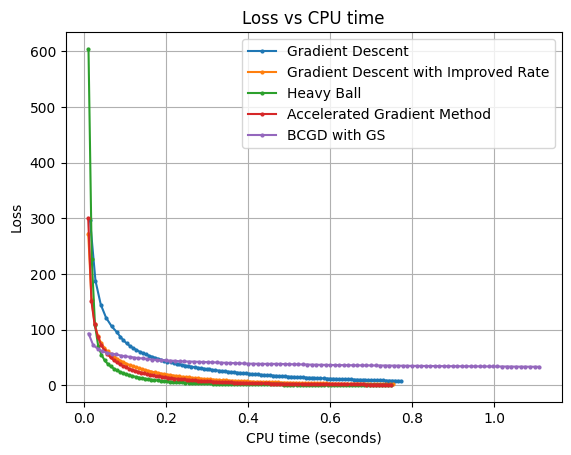

In [72]:
plt.plot(times_GD, loss_GD, marker='o', markersize = 2, label = 'Gradient Descent')
plt.plot(times_GDIR, loss_GDIR, marker='o', markersize = 2, label = 'Gradient Descent with Improved Rate')
plt.plot(times_HB, loss_HB, marker='o', markersize = 2, label = 'Heavy Ball')
plt.plot(times_AGM, loss_AGM, marker='o', markersize = 2, label = 'Accelerated Gradient Method')
plt.plot(times_BCGD, loss_BCGD, marker='o', markersize = 2, label = 'BCGD with GS')
plt.title("Loss vs CPU time")
plt.xlabel("CPU time (seconds)")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.savefig('loss_time_RD.png', dpi=300, bbox_inches='tight')
plt.show()

### How does the number of labeled samples impact our methods?

So far we have tried the implemented methods on our dataset considering the 5% of the data to remain as labeled samples. This is a summary of our results:

In [73]:
print('For 5% labeled data, the accuracies obtained with each method are:')
print(f'Gradient Descent: {accuracy_GD}')
print(f'Gradient Descent with Improved Rate: {accuracy_GDIR}')
print(f'Heavy Ball: {accuracy_HB}')
print(f'Accelerated Gradient Method: {accuracy_AGM}')
print(f'Block Coordinated Gradient Descent with Gauss-Southwell Rule: {accuracy_BCGD}\n')

For 5% labeled data, the accuracies obtained with each method are:
Gradient Descent: 0.8671586715867159
Gradient Descent with Improved Rate: 0.9298892988929889
Heavy Ball: 0.9391143911439115
Accelerated Gradient Method: 0.9317343173431735
Block Coordinated Gradient Descent with Gauss-Southwell Rule: 0.9446494464944649



We can repeat what we have done to see how much the accuracies change depending on the amount of labeled samples considered:

In [74]:
percentage_labeled_data = [0.01, 0.025, 0.075, 0.1]

for i in percentage_labeled_data:

    idx_class_0 = np.where(y == -1)[0]
    idx_class_1 = np.where(y == 1)[0]
    
    a_k = int(len(idx_class_0) * i) 
    b_k = int(len(idx_class_1) * i)
    
    a_indices = random.sample(list(idx_class_0), a_k)
    b_indices = random.sample(list(idx_class_1), b_k)
    
    
    class_1 = X[a_indices]
    class_2 = X[b_indices]
    
    
    remove_indices = set(a_indices + b_indices)
    keep_indices = [i for i in range(len(X)) if i not in remove_indices]
    
    
    X_unlabeled = X[keep_indices]
    y_unlabeled_true = y[keep_indices]
    
    X_labeled = np.concatenate((class_1,class_2))
    y_labeled = np.concatenate((y[a_indices],y[b_indices]))

    X_all = np.vstack([X_labeled, X_unlabeled])
    mean = X_all.mean(axis=0)
    std = X_all.std(axis=0) + 1e-8  
    
    X_labeled_scaled = (X_labeled - mean) / std
    X_unlabeled_scaled = (X_unlabeled - mean) / std

    weights_lu = compute_w_lu(X_labeled_scaled, X_unlabeled_scaled, sigma = 0.1)
    weights_uu = compute_w_uu(X_unlabeled_scaled, sigma = 0.1)

    best_alpha_GD, best_alpha_GDIR, best_HB, best_AGM = best_parameters(weights_lu, weights_uu)
    best_alpha_HB, best_beta_HB = best_HB
    best_alpha_AGM, best_beta_AGM = best_AGM

    y_final_pred_GD, accuracies_GD, loss_GD, times_GD = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GD, epochs=100)
    y_final_pred_GDIR, accuracies_GDIR, loss_GDIR, times_GDIR = Gradient_Descent_Method(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_GDIR, epochs=100)
    y_final_pred_HB, accuracies_HB, loss_HB, times_HB = Heavy_ball(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_HB, beta = best_beta_HB, epochs=100)
    y_final_pred_AGM, accuracies_AGM, loss_AGM, times_AGM = AGM(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, alpha = best_alpha_AGM, beta = best_beta_AGM, epochs=100)
    y_final_pred_BCGD, accuracies_BCGD, loss_BCGD, times_BCGD = BCGD_GS(X_unlabeled, y_unlabeled_true, y_labeled, weights_lu, weights_uu, max_epochs=100)

    accuracy_GD = accuracies_GD[-1]
    accuracy_GDIR = accuracies_GDIR[-1]
    accuracy_HB = accuracies_HB[-1]
    accuracy_AGM = accuracies_AGM[-1]
    accuracy_BCGD = accuracies_BCGD[-1]

    print(f'For {i*100}% labeled data, the accuracies obtained with each method are:')
    print(f'Gradient Descent: {accuracy_GD}')
    print(f'Gradient Descent with Improved Rate: {accuracy_GDIR}')
    print(f'Heavy Ball: {accuracy_HB}')
    print(f'Accelerated Gradient Method: {accuracy_AGM}')
    print(f'Block Coordinated Gradient Descent with Gauss-Southwell Rule: {accuracy_BCGD}\n')
    

For 1.0% labeled data, the accuracies obtained with each method are:
Gradient Descent: 0.5886524822695035
Gradient Descent with Improved Rate: 0.8528368794326241
Heavy Ball: 0.8404255319148937
Accelerated Gradient Method: 0.874113475177305
Block Coordinated Gradient Descent with Gauss-Southwell Rule: 0.6808510638297872

For 2.5% labeled data, the accuracies obtained with each method are:
Gradient Descent: 0.8165467625899281
Gradient Descent with Improved Rate: 0.8615107913669064
Heavy Ball: 0.9442446043165468
Accelerated Gradient Method: 0.908273381294964
Block Coordinated Gradient Descent with Gauss-Southwell Rule: 0.8776978417266187

For 7.5% labeled data, the accuracies obtained with each method are:
Gradient Descent: 0.8863636363636364
Gradient Descent with Improved Rate: 0.9147727272727273
Heavy Ball: 0.9204545454545454
Accelerated Gradient Method: 0.9375
Block Coordinated Gradient Descent with Gauss-Southwell Rule: 0.9166666666666666

For 10.0% labeled data, the accuracies obtain